# DATA - 603: PROJECT GROUP 4

# PART I - Google Open Image EDA and Wine Bottle Extraction 

In [6]:
# import the jupyter notebook importer
import import_ipynb
# from data603 import SparkLauncher
# from data603 import HDFSLauncher

import SparkLauncher
import HDFSLauncher



import pyspark.sql.functions as F 
from pyspark.sql.functions import col
from pyspark.sql.window import Window
from pyspark.sql.functions import monotonically_increasing_id, ntile
import os
conf = SparkLauncher.get_spark_conf()
conf.setAppName("Project_Group4")
# conf.set('spark.executor.memory', '200g')
# conf.set('spark.num.executors', 300)


# conf.set('spark.executor.memory', '200g')
conf.set('spark.num.executors', 500)  ## depending on bandwidth it may erro at 300, change to 200-100 

# increase memory
conf.set('spark.executor.memory', '500g') ### depending on bandwidth it may error at 300, change to 200-100

conf.set('spark.dynamicAllocation.executorIdleTimeout',190)
conf.set('spark.dynamicAllocation.maxExecutors', 500)
conf.set( 'spark.executor.cores', '32')


# conf.set("spark.sql.execution.arrow.enabled", "false")
spark = SparkLauncher.get_spark_session(conf, pack_venv = False)  #must set to TRUE !! due to keras_OCR but unable to execute
hdfs = HDFSLauncher.get_hdfs()
hdfs = HDFSLauncher.get_hdfs()


Creating Spark Session: Project_Group4


In [4]:
import pandas as pd

import pyspark.sql.functions as F 
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, StringType, IntegerType, BinaryType, ArrayType
import keras_ocr
from pyspark.sql.functions import col
from pyspark.sql.window import Window
from pyspark.sql.functions import monotonically_increasing_id, ntile
import os
import easyocr
import keras_ocr
import warnings
import tempfile
import io
import keras_ocr
import tensorflow as tf
from keras.preprocessing.image import load_img
from PIL import Image
import seaborn as sns



In [7]:
conf.getAll()

[('spark.eventLog.enabled', 'true'),
 ('spark.executor.extraLibraryPath',
  '/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/hadoop/lib/native'),
 ('spark.dynamicAllocation.maxExecutors', '500'),
 ('spark.driver.log.dfsDir', '/user/oe74376/driverLogs'),
 ('spark.yarn.appMasterEnv.MKL_NUM_THREADS', '1'),
 ('spark.sql.queryExecutionListeners',
  'com.cloudera.spark.lineage.NavigatorQueryListener'),
 ('spark.num.executors', '500'),
 ('spark.executor.memory', '500g'),
 ('spark.yarn.am.extraLibraryPath',
  '/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/hadoop/lib/native'),
 ('spark.ui.killEnabled', 'true'),
 ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
 ('spark.io.encryption.enabled', 'false'),
 ('spark.authenticate', 'false'),
 ('spark.app.name', 'Project_Group4'),
 ('spark.executor.cores', '32'),
 ('spark.submit.deployMode', 'client'),
 ('spark.yarn.am.memory', '2g'),
 ('spark.dynamicAllocation.executorIdleTimeout', '190'),
 ('spark.network.crypt

In [7]:
os.getcwd()

'/scratch/data603_sp2022/oe74376/Project'

## Examining the Metadata Files <a id ="1.2"></a>

In [8]:
hdfs.ls('/data/google_open_image/')

['/data/google_open_image/bboxes',
 '/data/google_open_image/ids',
 '/data/google_open_image/images',
 '/data/google_open_image/labels',
 '/data/google_open_image/masks',
 '/data/google_open_image/metadata',
 '/data/google_open_image/relationships',
 '/data/google_open_image/segmentations']

In [9]:
hdfs.ls('/data/google_open_image/metadata')

['/data/google_open_image/metadata/attributes-description.csv',
 '/data/google_open_image/metadata/class-descriptions-boxable.csv',
 '/data/google_open_image/metadata/classes-segmentation.txt',
 '/data/google_open_image/metadata/relationship-triplets.csv',
 '/data/google_open_image/metadata/relationships-description.csv']

In [10]:
hdfs.ls('/data/google_open_image/bboxes')

['/data/google_open_image/bboxes/test-annotations-bbox.csv',
 '/data/google_open_image/bboxes/train-annotations-bbox.csv',
 '/data/google_open_image/bboxes/validation-annotations-bbox.csv']

In [11]:
hdfs.ls('/etl/google_open_image/images/')

['/etl/google_open_image/images/test.avro',
 '/etl/google_open_image/images/train_0.avro',
 '/etl/google_open_image/images/train_1.avro',
 '/etl/google_open_image/images/train_2.avro',
 '/etl/google_open_image/images/train_3.avro',
 '/etl/google_open_image/images/train_4.avro',
 '/etl/google_open_image/images/train_5.avro',
 '/etl/google_open_image/images/train_6.avro',
 '/etl/google_open_image/images/train_7.avro',
 '/etl/google_open_image/images/train_8.avro',
 '/etl/google_open_image/images/train_9.avro',
 '/etl/google_open_image/images/train_a.avro',
 '/etl/google_open_image/images/train_b.avro',
 '/etl/google_open_image/images/train_c.avro',
 '/etl/google_open_image/images/train_d.avro',
 '/etl/google_open_image/images/train_e.avro',
 '/etl/google_open_image/images/train_f.avro',
 '/etl/google_open_image/images/validation.avro']

In [12]:
# Exploring the parquet files present in etl folder
hdfs.ls('/etl/google_open_image')

['/etl/google_open_image/images',
 '/etl/google_open_image/images.parquet',
 '/etl/google_open_image/images_coalesced.parquet',
 '/etl/google_open_image/images_partitioned_sample.parquet',
 '/etl/google_open_image/images_updated.parquet']

In [13]:
# Image Label CSV's
hdfs.ls('/data/google_open_image/labels')

['/data/google_open_image/labels/test-annotations-human-imagelabels-boxable.csv',
 '/data/google_open_image/labels/train-annotations-human-imagelabels-boxable.csv',
 '/data/google_open_image/labels/validation-annotations-human-imagelabels-boxable.csv']



## BOUNDING BOX 

In [14]:
hdfs.ls("/data/google_open_image/bboxes")

['/data/google_open_image/bboxes/test-annotations-bbox.csv',
 '/data/google_open_image/bboxes/train-annotations-bbox.csv',
 '/data/google_open_image/bboxes/validation-annotations-bbox.csv']

In [15]:
bb_all = spark.read.csv("/data/google_open_image/bboxes/*.csv", 
                          
                          header=True)

bb_all.count()

15851536

In [16]:
bb_df =  bb_all.limit(10).toPandas()
bb_df

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0
5,000002b66c9c498e,xclick,/m/01g317,1,0.320312,0.368750,0.260938,0.328125,1,0,0,0,0
6,000002b66c9c498e,xclick,/m/01g317,1,0.412500,0.945312,0.120312,0.475000,1,0,1,0,0
7,000002b66c9c498e,xclick,/m/0284d,1,0.528125,0.923437,0.675000,0.964063,0,0,0,0,0
8,000002b66c9c498e,xclick,/m/04bcr3,1,0.064062,0.492188,0.889063,0.993750,0,0,0,0,0
9,000002b66c9c498e,xclick,/m/04bcr3,1,0.301562,0.990625,0.462500,0.595312,0,0,0,0,0


# Reading the train, test and validation dataset

In [17]:
bb_train= pd.read_csv(hdfs.open("/data/google_open_image/bboxes/train-annotations-bbox.csv")) #, names=['LabelName', 'Desc'])
print(bb_train.size)
bb_train.head()

189932977


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0


In [18]:
bb_test= pd.read_csv(hdfs.open("/data/google_open_image/bboxes/test-annotations-bbox.csv")) #, names=['LabelName', 'Desc'])
print(bb_test.size)
bb_test.head()

12185251


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000026e7ee790996,xclick,/m/07j7r,1,0.071875,0.145313,0.206250,0.391667,0,1,1,0,0
1,000026e7ee790996,xclick,/m/07j7r,1,0.439063,0.571875,0.264583,0.435417,0,1,1,0,0
2,000026e7ee790996,xclick,/m/07j7r,1,0.668750,1.000000,0.000000,0.552083,0,1,1,0,0
3,000062a39995e348,xclick,/m/015p6,1,0.206208,0.849224,0.154639,1.000000,0,0,0,0,0
4,000062a39995e348,xclick,/m/05s2s,1,0.137472,0.376940,0.000000,0.883652,1,1,0,0,0


In [19]:
bb_validation= pd.read_csv(hdfs.open("/data/google_open_image/bboxes/validation-annotations-bbox.csv")) #, names=['LabelName', 'Desc'])
print(bb_validation.size)
bb_validation.head()

3951740


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,0001eeaf4aed83f9,xclick,/m/0cmf2,1,0.022673,0.964200,0.071038,0.800546,0,0,0,0,0
1,000595fe6fee6369,xclick,/m/02wbm,1,0.000000,1.000000,0.000000,1.000000,0,0,1,0,0
2,000595fe6fee6369,xclick,/m/02xwb,1,0.141384,0.179676,0.676275,0.731707,0,0,0,0,0
3,000595fe6fee6369,xclick,/m/02xwb,1,0.213549,0.253314,0.299335,0.354767,1,0,0,0,0
4,000595fe6fee6369,xclick,/m/02xwb,1,0.232695,0.288660,0.490022,0.545455,1,0,0,0,0


# EDA

# Checking for the consistency in the dataset¶

In [20]:
#checking for the null values in the dataset
bb_test.isnull().sum()

ImageID        0
Source         0
LabelName      0
Confidence     0
XMin           0
XMax           0
YMin           0
YMax           0
IsOccluded     0
IsTruncated    0
IsGroupOf      0
IsDepiction    0
IsInside       0
dtype: int64

In [21]:
bb_train.isnull().sum()

ImageID        0
Source         0
LabelName      0
Confidence     0
XMin           0
XMax           0
YMin           0
YMax           0
IsOccluded     0
IsTruncated    0
IsGroupOf      0
IsDepiction    0
IsInside       0
dtype: int64

In [22]:
bb_validation.isnull().sum()

ImageID        0
Source         0
LabelName      0
Confidence     0
XMin           0
XMax           0
YMin           0
YMax           0
IsOccluded     0
IsTruncated    0
IsGroupOf      0
IsDepiction    0
IsInside       0
dtype: int64

Its good to see that there are no null values in the dataset!

In [23]:
print('Unique Confidence Values in test dataset:', bb_test['Confidence'].unique())
print('Unique Confidence Values in train dataset:', bb_train['Confidence'].unique())
print('Unique Confidence Values in validation dataset:', bb_validation['Confidence'].unique())

Unique Confidence Values in test dataset: [1]
Unique Confidence Values in train dataset: [1]
Unique Confidence Values in validation dataset: [1]


In [24]:
bb_test.groupby('LabelName')[['ImageID','Confidence']].agg({'ImageID' : 'count', 'Confidence':'mean'}). reset_index()

,LabelName,ImageID,Confidence
0,/m/011k07,196,1
1,/m/012074,59,1
2,/m/0120dh,189,1
3,/m/01226z,243,1
4,/m/012n7d,77,1
...,...,...,...
578,/m/0ph39,378,1
579,/m/0qjjc,31,1
580,/m/0qmmr,306,1
581,/m/0wdt60w,31,1


This shows that the data is consistent in all the dataset. There are no null values and the Confidence values for all the images is 1.

The Source column indicates how the box was created:

**"freeform" and "xclick"** are human drawn boxes.

**"activemil"** are boxes human verified to be tight (IoU > 0.7) through an Active MIL process.

In [25]:
print('Image Source in test dataset:', bb_test['Source'].unique())
print('Image Source in train dataset:',bb_train['Source'].unique())
print('Image Source in validation dataset:',bb_validation['Source'].unique())

Image Source in test dataset: ['xclick']
Image Source in train dataset: ['xclick' 'activemil']
Image Source in validation dataset: ['xclick']


The above results show that except train dataset, test and validation dataset contains images in which box was created by humans. However, in train dataset boxes are human verified through an Active MIL Process. Lets see the count of images having source **xclick and activemil** in train dataset.

In [26]:
bb_train['Source'].value_counts()

xclick       13050532
activemil     1559697
Name: Source, dtype: int64

# Reading the class dataset

In [27]:
class_desc=pd.read_csv(hdfs.open("/data/google_open_image/metadata/class-descriptions-boxable.csv"),header=None, names=['LabelName', 'Desc'])


Let's join class_desc and test datset to see the attributes and labels.

In [28]:
bb_class = pd.merge(bb_test, class_desc, left_on='LabelName', right_on='LabelName', how='inner')
bb_class

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,Desc
0,000026e7ee790996,xclick,/m/07j7r,1,0.071875,0.145313,0.206250,0.391667,0,1,1,0,0,Tree
1,000026e7ee790996,xclick,/m/07j7r,1,0.439063,0.571875,0.264583,0.435417,0,1,1,0,0,Tree
2,000026e7ee790996,xclick,/m/07j7r,1,0.668750,1.000000,0.000000,0.552083,0,1,1,0,0,Tree
3,0002ab0af02e4a77,xclick,/m/07j7r,1,0.000000,1.000000,0.083032,0.397112,0,0,1,0,0,Tree
4,0003d84e0165d630,xclick,/m/07j7r,1,0.000000,0.998437,0.000000,0.247917,1,1,1,0,0,Tree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937322,f41e84b53ff978a1,xclick,/m/03wvsk,1,0.062500,1.000000,0.283333,1.000000,1,1,0,0,0,Hair dryer
937323,dc8a740db5afbd74,xclick,/m/02vwcm,1,0.148968,0.718289,0.000000,0.542035,1,1,0,0,0,Whisk
937324,e6cb4ea00293802d,xclick,/m/08ks85,1,0.000000,0.147710,0.613687,0.823400,1,1,0,0,0,Pizza cutter
937325,f8363004afb079a8,xclick,/m/02d1br,1,0.082812,0.920312,0.185417,0.760417,0,0,0,0,0,Spatula


# Google OpenImage attributes (https://github.com/openimages/dataset/blob/main/READMEV3.md):

    IsOccluded: Indicates that the object is occluded by another object in the image.
    
    IsTruncated: Indicates that the object extends beyond the boundary of the image.
    
    IsGroupOf: Indicates that the box spans a group of objects (e.g., a bed of flowers or a crowd of people).
    
    IsDepiction: Indicates that the object is a depiction (e.g., a cartoon or drawing of the object, not a real physical instance).
    
    IsInside: Indicates a picture taken from the inside of the object (e.g., a car interior or inside of a building).


In [29]:
#let's see the distribution of the image attributes and plot it
class_stat = bb_class.groupby('Desc')[['IsOccluded','IsTruncated','IsGroupOf','IsDepiction','IsInside']].sum().reset_index()
class_stat.head(5)

,Desc,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,Accordion,12,15,0,2,0
1,Adhesive tape,0,1,0,0,0
2,Aircraft,196,199,64,14,25
3,Airplane,557,916,97,64,25
4,Alarm clock,3,3,0,0,0


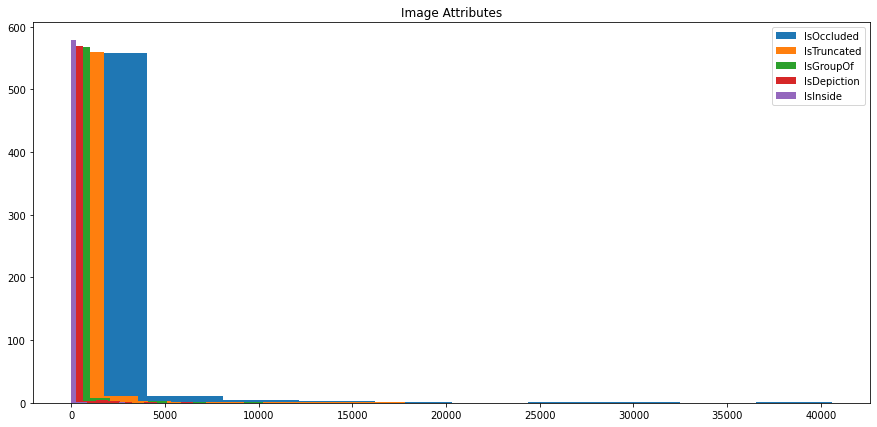

In [30]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize = (15, 7))
plt.hist(class_stat['IsOccluded'])

plt.hist(class_stat['IsTruncated'])

plt.hist(class_stat['IsGroupOf'])
plt.hist(class_stat['IsDepiction'])
plt.hist(class_stat['IsInside'])
plt.legend(['IsOccluded','IsTruncated','IsGroupOf','IsDepiction','IsInside'])
plt.title('Image Attributes')
 
# Show Plot
plt.show()

Out of all the subsets of the images, there are only few labels which has higher values for the image attributes. Let's see the distribution for LabelName with the top 50 'IsIoccluded' images with its other image attributes.

In [31]:
top_50 = class_stat.nlargest(n=50, columns= ['IsOccluded'])
top_50

,Desc,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
309,Mammal,40592,17785,4180,4461,24
111,Clothing,30520,14694,4572,4218,26
366,Person,27151,12446,6858,6524,116
564,Wheel,25483,3031,290,258,9
249,Human arm,20066,5706,783,1728,7
251,Human body,17251,15663,3034,2366,11
310,Man,15560,9144,1370,748,2
536,Tree,15278,12805,10245,363,15
519,Tire,14433,1909,142,233,0
87,Car,11101,9281,1932,287,464


<AxesSubplot:>

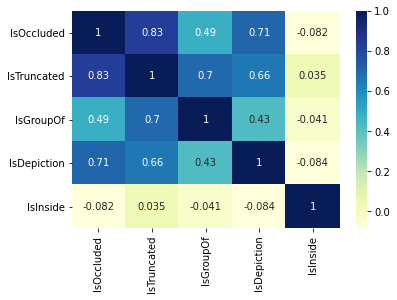

In [32]:
import seaborn as sns
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(top_50.corr(),cmap="YlGnBu", annot=True)

Above correlation heatmap reflects that 'IsInside' is weakly and negatively correlated with the other image attributes. 'IsTruncated' and 'IsDepiction' are strongly correlated IsOccluded values.

Now let's filter the **wine and bottle** images labels from the class_desc dataset.

In [33]:
class_desc.query('Desc=="Wine"')
class_desc[class_desc.Desc.isin(['Wine','Bottle'])]

,LabelName,Desc
285,/m/04dr76w,Bottle
406,/m/081qc,Wine


In [34]:
class_desc[class_desc.Desc.isin(['Wine','Bottle'])]['LabelName']

285    /m/04dr76w
406      /m/081qc
Name: LabelName, dtype: object

In [35]:
#filtering the test dataset only for the wine and bottle images
wine_and_bottle = bb_class[bb_class['LabelName'].isin(['/m/04dr76w','/m/081qc'])].reset_index(drop=True)
wine_and_bottle

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,Desc
0,004a9745418ba5a6,xclick,/m/04dr76w,1,0.035556,0.971111,0.024963,0.958884,0,0,0,0,0,Bottle
1,004f40769dcc358f,xclick,/m/04dr76w,1,0.254688,0.920312,0.000000,0.997917,0,1,0,0,0,Bottle
2,008ed2884d0fab85,xclick,/m/04dr76w,1,0.261429,0.771429,0.171233,0.917808,0,0,0,0,0,Bottle
3,00b729b5187a1898,xclick,/m/04dr76w,1,0.462500,0.683333,0.095312,0.853125,0,0,0,0,0,Bottle
4,010006993a980b92,xclick,/m/04dr76w,1,0.001473,0.362297,0.000000,0.698448,1,1,0,0,0,Bottle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2650,fc72b609ff76af53,xclick,/m/081qc,1,0.505900,0.550148,0.475664,0.595133,1,0,0,0,0,Wine
2651,fc72b609ff76af53,xclick,/m/081qc,1,0.728614,0.837758,0.674779,0.789823,0,0,0,0,0,Wine
2652,fe37deb726bd3c8c,xclick,/m/081qc,1,0.100000,0.147917,0.371875,0.435937,0,0,0,0,0,Wine
2653,fe37deb726bd3c8c,xclick,/m/081qc,1,0.520833,0.583333,0.364063,0.398438,0,0,0,0,0,Wine


In [36]:
#counting the images for both wine and bottles in the dataset
wine_and_bottle[['Desc','LabelName']].value_counts()

Desc    LabelName 
Bottle  /m/04dr76w    1480
Wine    /m/081qc      1175
dtype: int64

In [37]:
#grouping the wine and bottles dataset with agg function to determine the image demographics
agg_func = {'LabelName':'count',
           'IsOccluded' : 'sum',
           'IsTruncated': 'sum',
           'IsDepiction': 'sum',
           'IsGroupOf' : 'sum',
           'IsInside' : 'sum'}
image_att = wine_and_bottle.groupby('Desc')[['LabelName','IsOccluded','IsTruncated','IsGroupOf','IsDepiction','IsInside']].agg(agg_func).reset_index()
image_att.rename(columns={'LabelName':'Total Images'}, inplace=True)
image_att

,Desc,Total Images,IsOccluded,IsTruncated,IsDepiction,IsGroupOf,IsInside
0,Bottle,1480,532,477,33,277,0
1,Wine,1175,740,105,10,76,0


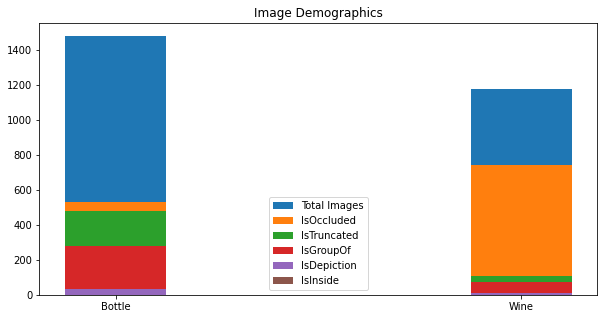

In [38]:
#plotting the above results
f, ax = plt.subplots(figsize=(10, 5))
plt.bar(image_att['Desc'],image_att['Total Images'],width = 0.25)
plt.bar(image_att['Desc'],image_att['IsOccluded'],width = 0.25)
plt.bar(image_att['Desc'],image_att['IsTruncated'],width = 0.25)
plt.bar(image_att['Desc'],image_att['IsGroupOf'],width = 0.25)
plt.bar(image_att['Desc'],image_att['IsDepiction'],width = 0.25)
plt.bar(image_att['Desc'],image_att['IsInside'],width = 0.25)
plt.legend(['Total Images','IsOccluded','IsTruncated','IsGroupOf','IsDepiction','IsInside'])
plt.title('Image Demographics')

plt.show()

Above plot gives us an idea that of the total images in both bottle and wine category **IsTruncated** images are comparatively more in wine cateogry then bottles. It is noteworthy that there is no 'IsInside' images in any of the category which makes sense as its not possible to take pictures from inside the wine and bottles.

33 and 10 pictures are drawing or cartoon in bottle and wine category respectively.

In [39]:

class_stat.describe(percentiles=[.25,.50,.75,.85,.90,.95,.99])




,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
count,583.000000,583.000000,583.000000,583.000000,583.000000
mean,715.948542,363.176672,139.000000,75.536878,11.945111
std,3236.828125,1607.662159,764.037139,444.503041,127.894355
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,11.000000,1.000000,0.000000,0.000000
50%,33.000000,35.000000,5.000000,2.000000,0.000000
75%,137.500000,96.000000,29.000000,8.000000,0.000000
85%,317.400000,190.200000,74.800000,21.700000,1.000000
90%,676.000000,371.200000,135.000000,45.800000,4.000000
95%,2709.300000,1340.900000,354.200000,218.400000,13.000000


In [40]:
class_stat.query("Desc=='Wine'|Desc=='Bottle'")

,Desc,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
55,Bottle,532,477,277,33,0
571,Wine,740,105,76,10,0


## Bottle and wine images are above the the 85th percentile of total images Occluded --> will make classification difficult
## Bottle and wine images are above the the 75th percentile of total images Truncated --> this will help the image classification
## Bottle and wine images are above the the 85th percentile of total images part of a group --> will make classification difficult
## Bottle and wine images are above the the 75th percentile of total images depicted --> not actually a wine or bottle image 
## Bottle and wine images are below the 85% percentile of total images inside other images --> good, our images are not inside another object

------------------------------------------------------------------------------------------------------

# Filter Wine Images that are aslo bottle Images (Hence Wine Bottles)

In [41]:
#Train dataset of wine/bottle
print('bounding box images with wine/bottle', bb_train[bb_train.LabelName.isin(['/m/04dr76w', '/m/081qc'])].shape)
wine_train = bb_train[bb_train.LabelName.isin(['/m/081qc'])]
bottle_train = bb_train[bb_train.LabelName.isin(['/m/04dr76w'])]
wine_bottles_id_train= wine_train.merge(bottle_train, on='ImageID', how='inner')['ImageID'].drop_duplicates()
wine_bottles_id_train=pd.DataFrame(wine_bottles_id_train)
wine_bottle_train = wine_train[wine_train['ImageID'].isin(wine_bottles_id_train['ImageID'])]
wine_bottle_train.shape

bounding box images with wine/bottle (55588, 13)


(7906, 13)

In [42]:
#Test dataset of wine/bottle
print('bounding box images with wine/bottle', bb_test[bb_test.LabelName.isin(['/m/04dr76w', '/m/081qc'])].shape)
wine_test = bb_test[bb_test.LabelName.isin(['/m/081qc'])]
bottle_test = bb_test[bb_test.LabelName.isin(['/m/04dr76w'])]
wine_bottles_id_test= wine_test.merge(bottle_test, on='ImageID', how='inner')['ImageID'].drop_duplicates()
wine_bottles_id_test=pd.DataFrame(wine_bottles_id_test)
wine_bottle_test = wine_test[wine_test['ImageID'].isin(wine_bottles_id_test['ImageID'])]
wine_bottle_test.shape

bounding box images with wine/bottle (2655, 13)


(264, 13)

In [43]:
hdfs.ls('/etl/google_open_image/images/')

['/etl/google_open_image/images/test.avro',
 '/etl/google_open_image/images/train_0.avro',
 '/etl/google_open_image/images/train_1.avro',
 '/etl/google_open_image/images/train_2.avro',
 '/etl/google_open_image/images/train_3.avro',
 '/etl/google_open_image/images/train_4.avro',
 '/etl/google_open_image/images/train_5.avro',
 '/etl/google_open_image/images/train_6.avro',
 '/etl/google_open_image/images/train_7.avro',
 '/etl/google_open_image/images/train_8.avro',
 '/etl/google_open_image/images/train_9.avro',
 '/etl/google_open_image/images/train_a.avro',
 '/etl/google_open_image/images/train_b.avro',
 '/etl/google_open_image/images/train_c.avro',
 '/etl/google_open_image/images/train_d.avro',
 '/etl/google_open_image/images/train_e.avro',
 '/etl/google_open_image/images/train_f.avro',
 '/etl/google_open_image/images/validation.avro']

In [45]:
train_path ='/etl/google_open_image/images/train*'
images_train = spark.read.format("com.databricks.spark.avro").load(train_path )
images_train = images_train.withColumn('id', F.lower(F.col("id"))).withColumnRenamed('id','ImageId')
print('train: ', images_train.count())
test_path ='/etl/google_open_image/images/test.avro'
images_test = spark.read.format("com.databricks.spark.avro").load(test_path )
images_test = images_test.withColumn('id', F.lower(F.col("id"))).withColumnRenamed('id','ImageId')
print('test: ', images_test.count())

train:  1743042
test:  125436


In [46]:
images_train = images_train.where(col('ImageId').isin(list(wine_bottles_id_train.ImageID)))
wine_images_train = images_train.join(bb_all, on = 'ImageId', how = 'inner').filter("LabelName == '/m/081qc'")
print('train: ', wine_images_train.count())
images_test = images_test.where(col('ImageId').isin(list(wine_bottles_id_test.ImageID)))
wine_images_test = images_test.join(bb_all, on = 'ImageId', how = 'inner').filter("LabelName == '/m/081qc'")

print('test: ', wine_images_test.count())

train:  7906
test:  264


In [ ]:
# os.getcwd()
# hdfs.mkdir('/user/oe74376/Project')
# hdfs.ls('/user/oe74376/Project')

In [47]:
path ='/etl/google_open_image/images/*.avro'
images = spark.read.format("com.databricks.spark.avro").load(path)
images = images.withColumn('id', F.lower(F.col("id"))).withColumnRenamed('id','ImageId')
print('all: ', images.count())
images.show(2)

all:  1910098
+----------------+----------+------+--------------------+
|         ImageId|    subset|format|                data|
+----------------+----------+------+--------------------+
|2b13330e9197afa9|VALIDATION|   JPG|[FF D8 FF E0 00 1...|
|f3276b944bbb9874|VALIDATION|   JPG|[FF D8 FF E0 00 1...|
+----------------+----------+------+--------------------+
only showing top 2 rows



In [48]:
wine_images_train = wine_images_train.withColumn("XMin", wine_images_train['XMin'].cast(DoubleType()))
wine_images_train = wine_images_train.withColumn("XMax", wine_images_train['XMax'].cast(DoubleType()))
wine_images_train = wine_images_train.withColumn("YMin", wine_images_train['YMin'].cast(DoubleType()))
wine_images_train = wine_images_train.withColumn("YMax", wine_images_train['YMax'].cast(DoubleType()))
wine_images_train = wine_images_train.withColumn("Confidence", wine_images_train['Confidence'].cast(DoubleType()))

wine_images_test = wine_images_test.withColumn("XMin", wine_images_test['XMin'].cast(DoubleType()))
wine_images_test = wine_images_test.withColumn("XMax", wine_images_test['XMax'].cast(DoubleType()))
wine_images_test = wine_images_test.withColumn("YMin", wine_images_test['YMin'].cast(DoubleType()))
wine_images_test = wine_images_test.withColumn("YMax", wine_images_test['YMax'].cast(DoubleType()))
wine_images_test = wine_images_test.withColumn("Confidence", wine_images_test['Confidence'].cast(DoubleType()))

wine_images_test.printSchema()

root
 |-- ImageId: string (nullable = true)
 |-- subset: string (nullable = true)
 |-- format: string (nullable = true)
 |-- data: binary (nullable = true)
 |-- Source: string (nullable = true)
 |-- LabelName: string (nullable = true)
 |-- Confidence: double (nullable = true)
 |-- XMin: double (nullable = true)
 |-- XMax: double (nullable = true)
 |-- YMin: double (nullable = true)
 |-- YMax: double (nullable = true)
 |-- IsOccluded: string (nullable = true)
 |-- IsTruncated: string (nullable = true)
 |-- IsGroupOf: string (nullable = true)
 |-- IsDepiction: string (nullable = true)
 |-- IsInside: string (nullable = true)



In [50]:
wine_test_df = wine_images_test.toPandas()
wine_test_df.head(2)

,ImageId,subset,format,data,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,c8ad1131768eebc3,VALIDATION,JPG,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",xclick,/m/081qc,1.0,0.0,1.0,0.050773,0.927152,0,0,1,0,0
1,44d324ebd3e22ad7,VALIDATION,JPG,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",xclick,/m/081qc,1.0,0.0,1.0,0.340708,0.763274,0,0,1,0,0


In [51]:
wine_test_df.groupby('ImageId').agg(
                        box_count=('LabelName', 'size'),
                        box_unique=('LabelName', 'nunique')
                        ).sort_values('box_count', ascending=False)

,box_count,box_unique
ImageId,,
3874b93b81fab210,45,1
a2ed20cbf9bab7a2,31,1
0bcf21f43f327741,7,1
3e5601511f20796c,6,1
0ca790da12c776d6,6,1
...,...,...
b29c1e36ed575ca4,1,1
bb9328e857b6188a,1,1
704df7f8d1059b57,1,1


Now, let's explore some data for the above results.

In [ ]:
#intalling hvplot packages 
#!pip install hvplot

Let'se see how annotations are distributed in the dataset.

In [52]:
#creating dataframe by performing group by on the ImageId to aggregate the box_count and box_unique annotations.
annotations = wine_test_df.groupby('ImageId').agg(
                        box_count=('LabelName', 'size'),
                        box_unique=('LabelName', 'nunique')
                        )

pd.options.display.float_format = '{:,.1f}'.format
annotations.describe()

,box_count,box_unique
count,96.0,96.0
mean,2.8,1.0
std,5.4,0.0
min,1.0,1.0
25%,1.0,1.0
50%,2.0,1.0
75%,3.0,1.0
max,45.0,1.0


Above statistics shows that out of 264 datapoints
there are 96 distinct ImageId with average box_count per images in the dataset is 2.8. 50% of the dataset has 2 box counts per image. Unique box counts are 1 for all the ImageId. Noteworthy point from the above result is there is one Image with maximum 45 box_counts. Let's fetch that ImageId.

In [53]:
annotations.sort_values('box_count',ascending=False)

,box_count,box_unique
ImageId,,
3874b93b81fab210,45,1
a2ed20cbf9bab7a2,31,1
0bcf21f43f327741,7,1
3e5601511f20796c,6,1
0ca790da12c776d6,6,1
...,...,...
b29c1e36ed575ca4,1,1
bb9328e857b6188a,1,1
704df7f8d1059b57,1,1


ImageId '3874b93b81fab210' has maximum box_count of 45 and 'a2ed20cbf9bab7a2' is the second maximum with 31 box_count. Let's plot the above results.

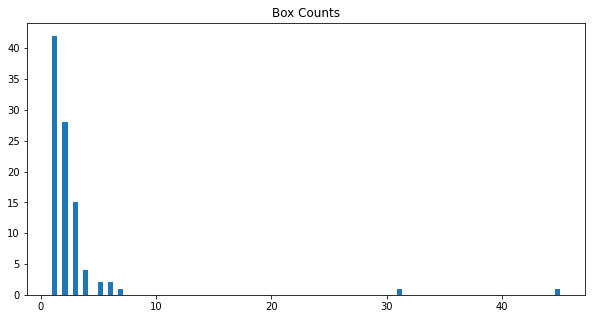

In [57]:
fig,ax = plt.subplots(figsize = (10, 5))
plt.hist(annotations['box_count'], bins=100)
plt.title('Box Counts')
 
# Show Plot
plt.show()

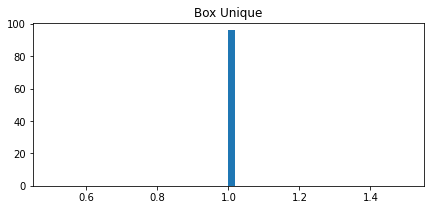

In [56]:
fig,ax = plt.subplots(figsize = (7, 3))
plt.hist(annotations['box_unique'], bins=50)
plt.title('Box Unique')
 
# Show Plot
plt.show()

Let's see the distribution of the number of boxes per image with largest 1% removed.

In [58]:
onepct = annotations.box_count.quantile(0.99)
X = annotations.query('box_count < @onepct').box_count.value_counts(normalize=True) \
    .sort_index()

Text(0.5, 1.0, 'box_count')

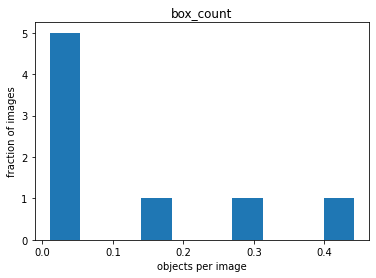

In [59]:

plt.hist(X)
#ax.set_xticks(list(range(0,60,10)))
plt.xlabel('objects per image')
plt.ylabel('fraction of images')
plt.title('box_count')

# STEP 2 - Load Data from STEP 1 and Predict Labels of Wine Bottles Using RESNET50

In [10]:
import pandas as pd
import pyspark.sql.functions as F 
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, StringType, IntegerType, BinaryType, ArrayType
import keras_ocr
from pyspark.sql.functions import col
from pyspark.sql.window import Window
from pyspark.sql.functions import monotonically_increasing_id, ntile
import os
import easyocr
import keras_ocr
import warnings
import tempfile
import io
import keras_ocr
import tensorflow as tf
from keras.preprocessing.image import load_img
from PIL import Image


In [11]:
print(hdfs.info('/user/oe74376/Project'))

{'path': 'hdfs://10.3.0.2:8020/user/oe74376/Project', 'owner': 'oe74376', 'group': 'hadoop', 'size': 0, 'block_size': 0, 'last_modified': 1652232482, 'last_accessed': 0, 'replication': 0, 'permissions': 493, 'kind': 'directory'}


In [12]:
project_path = '/user/oe74376/Project'
hdfs.ls(project_path)

['/user/oe74376/Project/images_wine_bottle_pred',
 '/user/oe74376/Project/images_wine_bottle_pred_train',
 '/user/oe74376/Project/images_wine_bottle_test_pred_text_step3',
 '/user/oe74376/Project/wine_images_test.avro',
 '/user/oe74376/Project/wine_images_test_v2.avro',
 '/user/oe74376/Project/wine_images_train.avro',
 '/user/oe74376/Project/wine_images_train_v2.avro']

In [13]:

wine_images_test = spark.read\
                         .format("com.databricks.spark.avro")\
                         .load('/user/oe74376/Project/wine_images_test.avro')

wine_images_train = spark.read\
                         .format("com.databricks.spark.avro")\
                         .load('/user/oe74376/Project/wine_images_train.avro')




In [14]:
wine_images_test.printSchema()

root
 |-- ImageID: string (nullable = true)
 |-- LabelName: string (nullable = true)
 |-- Confidence: double (nullable = true)
 |-- IsOccluded: string (nullable = true)
 |-- IsTruncated: string (nullable = true)
 |-- isGroupOf: string (nullable = true)
 |-- IsDepiction: string (nullable = true)
 |-- IsInside: string (nullable = true)
 |-- SubImageData: binary (nullable = true)



In [15]:
wine_images_train.count()

7906

In [16]:
wine_images_test.count()

264

In [17]:
# apply group id function 
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import col, lit, udf
from pyspark.sql.types import IntegerType

def group_id(n):
    ret = n % 10
    return ret

udf_group_id = udf(group_id, IntegerType())

# create the counter 1 - # of rows
wine_images_train= wine_images_train.withColumn("n", monotonically_increasing_id())

# modulo the counter to get a repeating pattern of 0,1,2,3,4,5,6,7,8,9 for the group number
wine_images_train = wine_images_train.withColumn("grp", udf_group_id("n"))

wine_images_test= wine_images_test.withColumn("n", monotonically_increasing_id())

# modulo the counter to get a repeating pattern of 0,1,2,3,4,5,6,7,8,9 for the group number
wine_images_test = wine_images_test.withColumn("grp", udf_group_id("n"))

In [18]:
# create two empty columns for result of udf
# wine_images_test = wine_images_test.withColumn('prediction_label', lit(""))
# wine_images_test =wine_images_test.withColumn('prediction_confidence', lit(0.0))

# wine_images_train = wine_images_train.withColumn('prediction_label', lit(""))
# wine_images_train =wine_images_train.withColumn('prediction_confidence', lit(0.0))

In [19]:
#quick under a minute
print(pd.Timestamp.now())
wine_df = wine_images_test.toPandas()
print(pd.Timestamp.now())

2022-05-11 12:34:56.595771
2022-05-11 12:35:00.956759


In [20]:
print(wine_df.shape)
wine_df.head()

(264, 11)


,ImageID,LabelName,Confidence,IsOccluded,IsTruncated,isGroupOf,IsDepiction,IsInside,SubImageData,n,grp
0,3e5601511f20796c,/m/081qc,1.0,0,0,1,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",0,0
1,3e5601511f20796c,/m/081qc,1.0,1,0,0,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",1,1
2,3e5601511f20796c,/m/081qc,1.0,1,0,1,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",2,2
3,3e5601511f20796c,/m/081qc,1.0,1,0,1,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",3,3
4,3e5601511f20796c,/m/081qc,1.0,1,0,1,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",4,4


# PRED IMAGES LABELS USING RESNET

In [21]:
import tensorflow as tf

def evaluate_img(data):
    import warnings
    import io
    import os
    import tempfile
    from tensorflow.keras.applications.resnet50 import ResNet50
    from tensorflow.keras.preprocessing import image
    from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
    import numpy as np
    from keras.preprocessing.image import load_img
    from keras.preprocessing.image import img_to_array
    import tensorflow as tf

    # img_bytes = io.BytesIO()
    # img = Image.open(io.BytesIO( data ))
    
    warnings.filterwarnings(action='once')
    
    # if type(tf.contrib) != type(tf): tf.contrib._warning = None
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
    
    with tempfile.TemporaryDirectory(dir=f'{os.getcwd()}') as td:
        f_name = os.path.join(td, 'img.jpeg')
        with open(f_name, 'wb') as fh:
            fh.write(data)
        img = load_img(f_name, target_size = (224,224,3))

    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
        
    # Load Model Data
    model = ResNet50(weights = 'imagenet', include_top=True)#f,'{os.getcwd()}/resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                 # ,include_top = True)  
    

    yhat = model.predict(img)

    # Decode Predictions
    label = decode_predictions(yhat)
    label = label[0][0]
    # ret = (label[1], float(label[2])   
    # pred=   label    
    # return label #str(label[0][0][1]) +","+ str(label[0][0][2])   
    return     label[1] +","+  str(label[2])   



udf_evaluate_img = F.udf(evaluate_img, StringType())

In [22]:
# TEST THE FUNCTION ON PYTHON BEFORE GOING INTO THE AVRO FILE
print(pd.Timestamp.now())

df_t=wine_df.head(1).copy(deep=True)
df_t['pred_label']=df_t.apply(lambda x : evaluate_img(x['SubImageData']), axis=1)

# df_t['predlabel'], df_t['predprob']= map(evaluate_img, df_t['SubImageData']))
print(pd.Timestamp.now())
df_t[['pred_label','pred_prob']]=df_t['pred_label'].str.split(',',expand=True) 
df_t

2022-05-11 12:35:01.057176
2022-05-11 12:35:09.509735


,ImageID,LabelName,Confidence,IsOccluded,IsTruncated,isGroupOf,IsDepiction,IsInside,SubImageData,n,grp,pred_label,pred_prob
0,3e5601511f20796c,/m/081qc,1.0,0,0,1,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",0,0,beer_bottle,0.273352


In [23]:
# #est 2 min
# print(pd.Timestamp.now())
# # _df_df['pred_label'], wine_df['predprob']= zip(*map(evaluate_img, wine_df['SubImageData']))
# # wine_df['pred_label']=wine_df.apply(lambda x : evaluate_img(x['SubImageData']), axis=1)
# wine_df['pred_label']=wine_df['SubImageData'].apply(lambda x : evaluate_img(x))
# wine_df[['pred_label','pred_prob']]=wine_df['pred_label'].str.split(',',expand=True) 
# print(pd.Timestamp.now())

In [24]:
# wine_images_test.where(wine_images_test['grp']==0).count()

In [25]:
#less than a min - secs lazy evaluation
wine_images_test_1= wine_images_test \
    .withColumn('pred_label', udf_evaluate_img(wine_images_test['SubImageData']))



In [26]:
#est 5 min
print(pd.Timestamp.now())
# wine_images_test_1.write.format('avro').mode('overwrite').option("header", "true").partitionBy("grp").save("/user/oe74376/Project/images_wine_bottle_pred")#.csv("/user/oe74376/Project/images_train_wine_bottle")
print(pd.Timestamp.now())



2022-05-11 12:35:09.808593
2022-05-11 12:35:09.808926


In [27]:
#est - 3 min  wine_images_train_1 works but ignore it--> wi
# print(pd.Timestamp.now())
# wine_images_train_1= wine_images_train \
#     .withColumn('pred_label', udf_evaluate_img(wine_images_train['SubImageData']))
# print(pd.Timestamp.now())

# print(pd.Timestamp.now())
# wine_images_train_1.write.format('avro').mode('overwrite').option("header", "true").partitionBy("grp").save("/user/oe74376/Project/images_wine_bottle_pred_train")#.csv("/user/oe74376/Project/images_train_wine_bottle")
# print(pd.Timestamp.now())

# print(pd.Timestamp.now())
# wine_images_train_1_df = wine_images_train_1.toPandas()
# print(pd.Timestamp.now())


# wine_images_train_1_df[['pred_label','pred_prob']]=wine_images_train_1_df['pred_label'].str.split(',',expand=True)   #query('pred_labe')
# wine_images_train_1_df.to_csv('wine_images_train_pred_labels.csv')
# print(pd.Timestamp.now())
# wine_images_train_1_df.head()

In [28]:
print(hdfs.info('/user/oe74376/Project'))
hdfs.ls('/user/oe74376/Project/images_wine_bottle_pred')


{'path': 'hdfs://10.3.0.2:8020/user/oe74376/Project', 'owner': 'oe74376', 'group': 'hadoop', 'size': 0, 'block_size': 0, 'last_modified': 1652232482, 'last_accessed': 0, 'replication': 0, 'permissions': 493, 'kind': 'directory'}


['/user/oe74376/Project/images_wine_bottle_pred/_SUCCESS',
 '/user/oe74376/Project/images_wine_bottle_pred/grp=0',
 '/user/oe74376/Project/images_wine_bottle_pred/grp=1',
 '/user/oe74376/Project/images_wine_bottle_pred/grp=2',
 '/user/oe74376/Project/images_wine_bottle_pred/grp=3',
 '/user/oe74376/Project/images_wine_bottle_pred/grp=4',
 '/user/oe74376/Project/images_wine_bottle_pred/grp=5',
 '/user/oe74376/Project/images_wine_bottle_pred/grp=6',
 '/user/oe74376/Project/images_wine_bottle_pred/grp=7',
 '/user/oe74376/Project/images_wine_bottle_pred/grp=8',
 '/user/oe74376/Project/images_wine_bottle_pred/grp=9']

In [29]:
# #est under a min
# print(pd.Timestamp.now())
# wine_images_test_1_df = wine_images_test_1.where(wine_images_test['grp']==0).toPandas()
# print(pd.Timestamp.now())

In [30]:
#est 6 min
print(pd.Timestamp.now())
wine_images_test_1_df = wine_images_test_1.toPandas()
print(pd.Timestamp.now())

2022-05-11 12:35:09.922961
2022-05-11 12:37:21.553984


/usr/lib64/python3.6/socket.py:657: ResourceWarning: unclosed <socket.socket fd=286, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 34242), raddr=('127.0.0.1', 39287)>
  self._sock = None


In [31]:
wine_images_test_1_df[['pred_label','pred_prob']]=wine_images_test_1_df['pred_label'].str.split(',',expand=True)   

wine_images_test_1_df.head()


,ImageID,LabelName,Confidence,IsOccluded,IsTruncated,isGroupOf,IsDepiction,IsInside,SubImageData,n,grp,pred_label,pred_prob
0,3e5601511f20796c,/m/081qc,1.0,0,0,1,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",0,0,beer_bottle,0.27335188
1,3e5601511f20796c,/m/081qc,1.0,1,0,0,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",1,1,digital_clock,0.26520517
2,3e5601511f20796c,/m/081qc,1.0,1,0,1,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",2,2,paintbrush,0.23806334
3,3e5601511f20796c,/m/081qc,1.0,1,0,1,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",3,3,otterhound,0.28727967
4,3e5601511f20796c,/m/081qc,1.0,1,0,1,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",4,4,chime,0.5954692


In [32]:
wine_images_test_1_df.to_csv('wine_images_test_pred_labels.csv')
wine_images_test_1_df.head()

,ImageID,LabelName,Confidence,IsOccluded,IsTruncated,isGroupOf,IsDepiction,IsInside,SubImageData,n,grp,pred_label,pred_prob
0,3e5601511f20796c,/m/081qc,1.0,0,0,1,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",0,0,beer_bottle,0.27335188
1,3e5601511f20796c,/m/081qc,1.0,1,0,0,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",1,1,digital_clock,0.26520517
2,3e5601511f20796c,/m/081qc,1.0,1,0,1,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",2,2,paintbrush,0.23806334
3,3e5601511f20796c,/m/081qc,1.0,1,0,1,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",3,3,otterhound,0.28727967
4,3e5601511f20796c,/m/081qc,1.0,1,0,1,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",4,4,chime,0.5954692


Text(0.5, 1.0, 'Top 10 Predicted Labels for Wine Bottles')

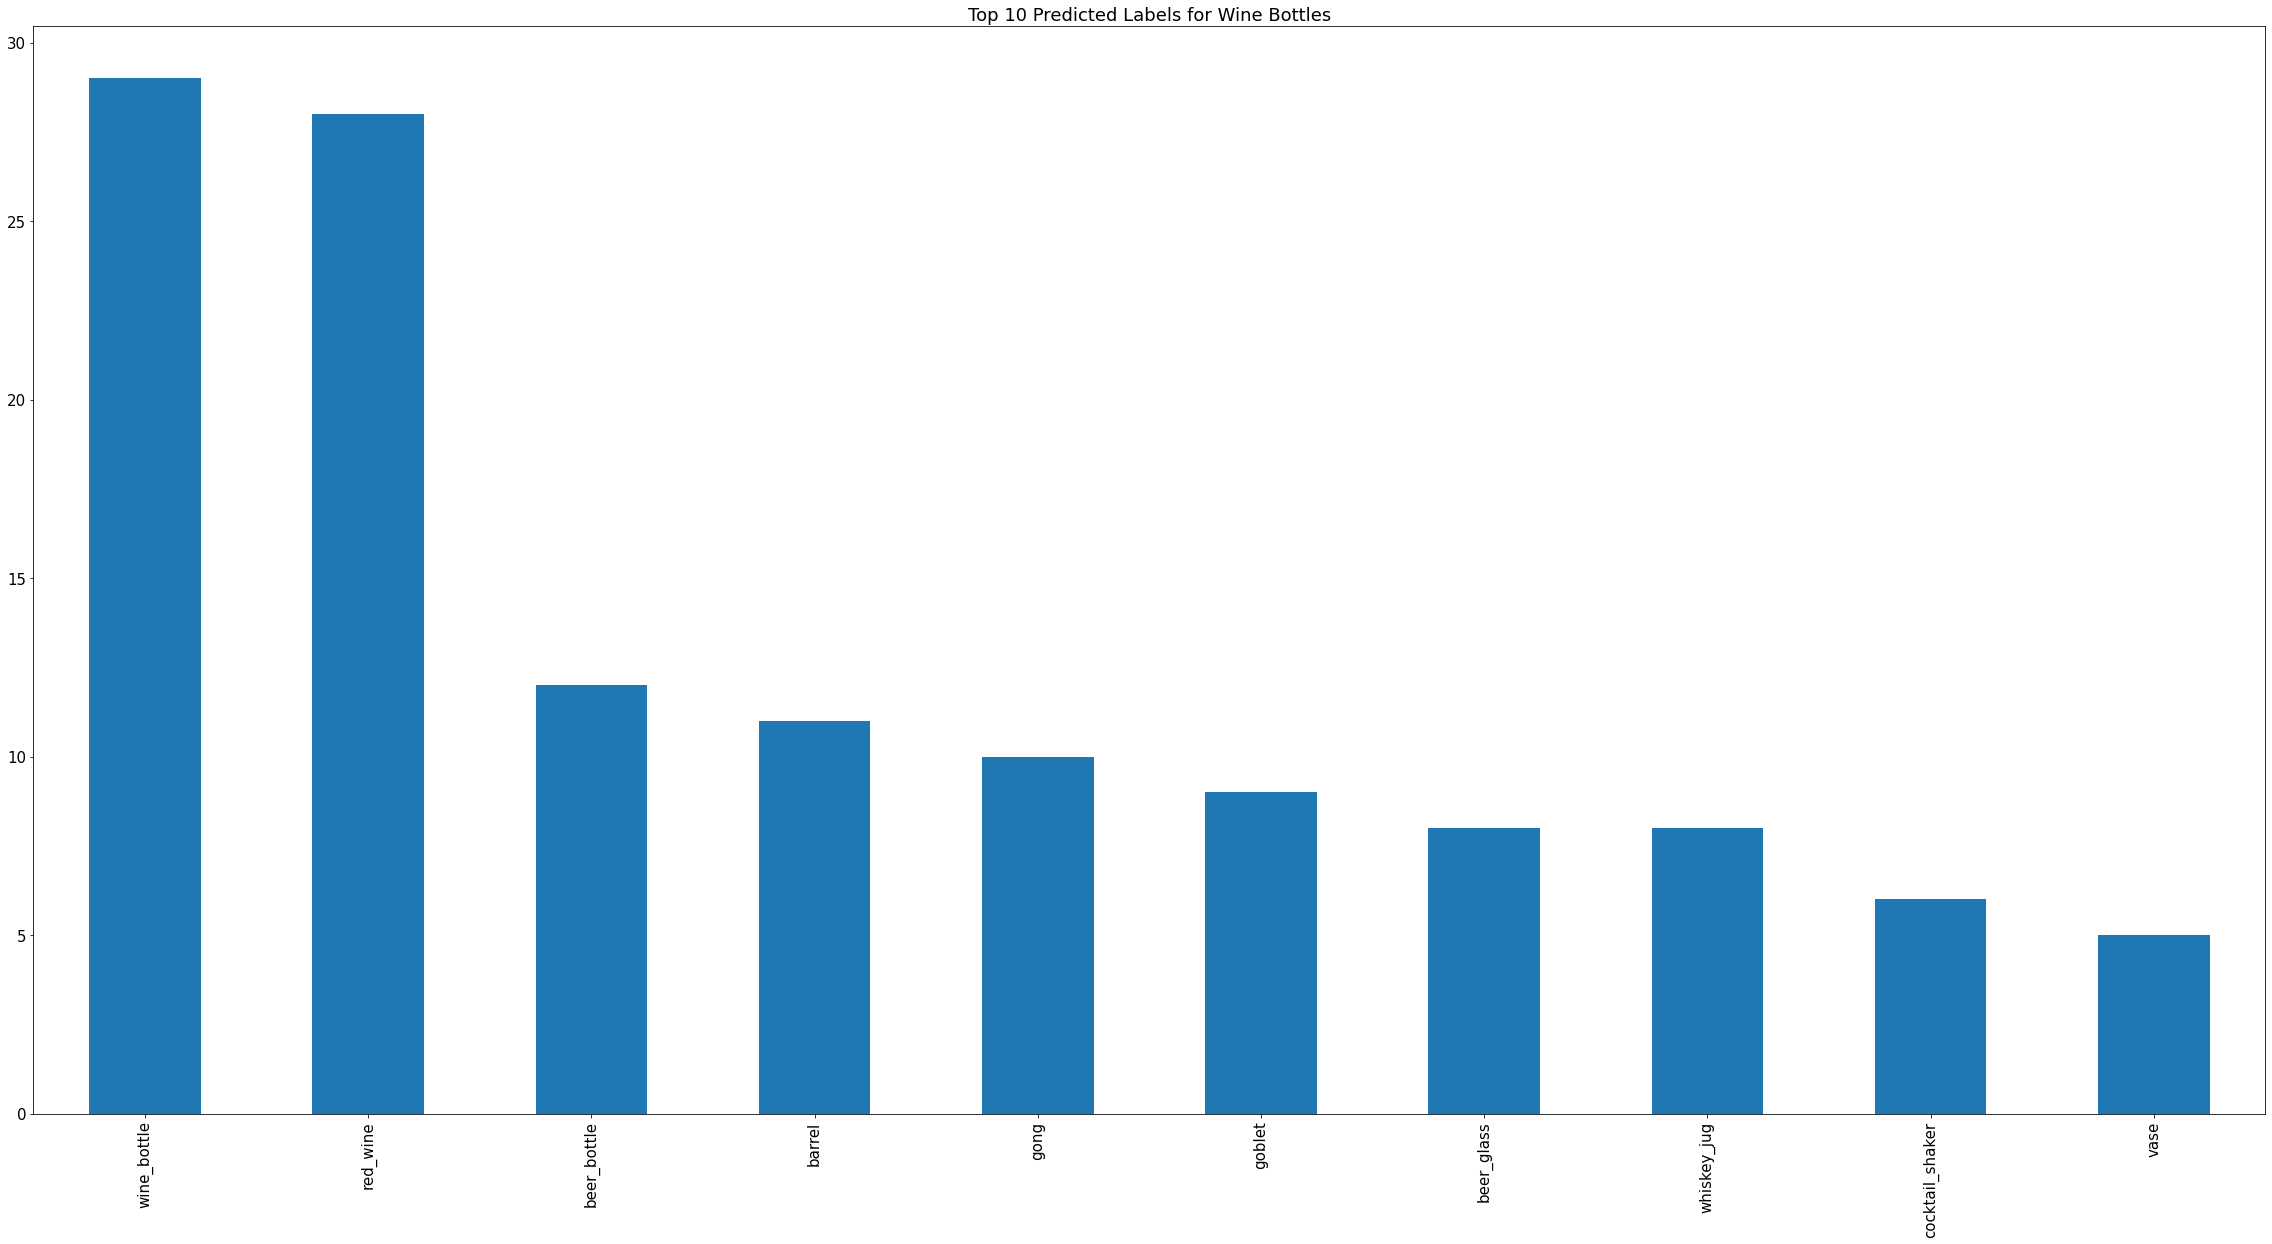

In [138]:
plt.rcParams.update({'font.size': 15})
wine_images_test_1_df.pred_label.value_counts().head(10).plot.bar(figsize=(40,20))
plt.title('Top 10 Predicted Labels for Wine Bottles')

# wine_images_test_1_df.pred_label.value_counts().head(10).sort_values().plot.barh(figsize=(30,30))

<AxesSubplot:>

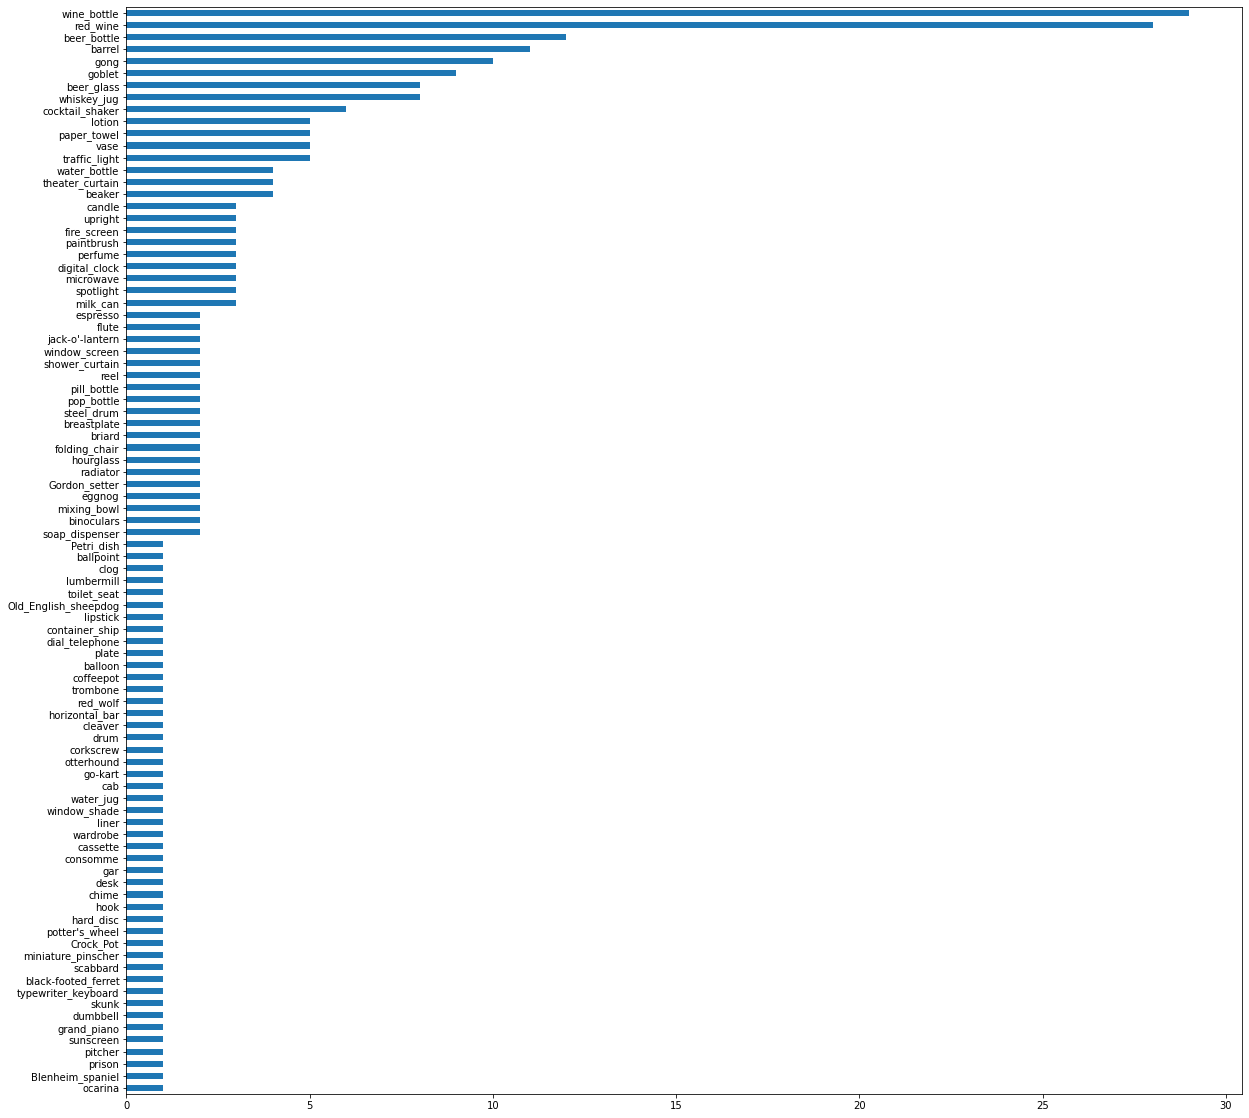

In [140]:
plt.rcParams.update({'font.size': 10})
wine_images_test_1_df.pred_label.value_counts().sort_values().plot.barh(figsize=(20,20))

In [34]:
# stop here

# PART 3 - Extract text from wine bottles using OCR and Easy OCR

In [35]:
import keras_ocr 
pipeline = keras_ocr.pipeline.Pipeline()
from matplotlib import pyplot as plt

Looking for /afs/umbc.edu/users/o/e/oe74376/home/.keras-ocr/craft_mlt_25k.h5
Looking for /afs/umbc.edu/users/o/e/oe74376/home/.keras-ocr/crnn_kurapan.h5


In [ ]:
print(hdfs.info('/user/oe74376/Project'))
hdfs.ls('/user/oe74376/Project/')

In [ ]:
#Load images if needed
# wine_images_train_1 = spark.read\
#                          .format("com.databricks.spark.avro")\
#                          .load('/user/oe74376/Project/images_wine_bottle_pred_train')

# wine_images_test_1 = spark.read\
#                          .format("com.databricks.spark.avro")\
#                          .load('/user/oe74376/Project/images_wine_bottle_pred')

In [ ]:
wine_images_test_1.printSchema()


In [ ]:
# run only if restarting kernel from PartII
#est 6 min  -- works before applying the ocr text extraction
print(pd.Timestamp.now())
#if needed
# wine_images_test_1_df = wine_images_test_1.toPandas()
# wine_images_test_1_df[['pred_label','pred_prob']]=wine_images_test_1_df['pred_label'].str.split(',',expand=True)   

print(pd.Timestamp.now())
wine_images_test_1_df.head()

# KERAS OCR -- Text Extraction takes an images and extracts the text -- RNN architecture

In [36]:
import warnings
import io
import os
import keras_ocr
import tensorflow as tf
from keras.preprocessing.image import load_img
from PIL import Image
warnings.filterwarnings("ignore")
pipeline = keras_ocr.pipeline.Pipeline()    
def get_text(data):
    import warnings
    import tempfile
    import io
    import os
    import keras_ocr
    import tensorflow as tf
    from keras.preprocessing.image import load_img
    from PIL import Image
    # warnings.filterwarnings(action='once')

    warnings.filterwarnings("ignore")
    
    # if type(tf.contrib) != type(tf): tf.contrib._warning = None
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
    
    # pipeline = keras_ocr.pipeline.Pipeline()
    global pipeline
    with tempfile.TemporaryDirectory(dir=f'{os.getcwd()}') as td:
        f_name = os.path.join(td, 'img.jpeg')
        with open(f_name, 'wb') as fh:
            fh.write(data)
        img = load_img(f_name)
        # img = Image.open(f_name) 
        # print(f_name)
        # print(img)
        img_text = pipeline.recognize([f_name])
    
    # print(img_text)
    text = " ".join([i[0] for i in img_text[0]])   
    
    try:
        # text = " ".join([bound[i][1] for i in range(len(img_text))]) 
        text = " ".join([i[0] for i in img_text[0]])

    except Exception as e:
        text='-999999'
        pass
    # print(text)
    return text


udf_get_text = F.udf(get_text, StringType())



Looking for /afs/umbc.edu/users/o/e/oe74376/home/.keras-ocr/craft_mlt_25k.h5
Looking for /afs/umbc.edu/users/o/e/oe74376/home/.keras-ocr/crnn_kurapan.h5


In [37]:
#est 30min
print(pd.Timestamp.now())
# wine_images_test_1_df['ocr']= zip(*map(get_text, wine_df['SubImageData']))
 
# wine_images_test_1_df['ocr']= wine_images_test_1_df['SubImageData'].head(1).apply(lambda x: get_text(x))
wine_images_test_1_df['ocr'] = wine_images_test_1_df['SubImageData'].apply(lambda x: get_text(x))
wine_images_test_1_df.to_csv('wine_images_test_pred_labels.csv')
print(pd.Timestamp.now()) 

2022-05-11 12:41:02.094616
2022-05-11 12:46:47.019608


In [38]:
# wine_images_test_1_df.head()['ocr']
wine_images_test_1_df['pred_label'].value_counts()

wine_bottle     29
red_wine        28
beer_bottle     12
barrel          11
gong            10
                ..
cab              1
water_jug        1
window_shade     1
Petri_dish       1
ballpoint        1
Name: pred_label, Length: 90, dtype: int64

In [39]:

wine_images_test_1_df.query('pred_label=="wine_bottle"').head()

,ImageID,LabelName,Confidence,IsOccluded,IsTruncated,isGroupOf,IsDepiction,IsInside,SubImageData,n,grp,pred_label,pred_prob,ocr
6,6e3b7f53e8b75c69,/m/081qc,1.0,0,0,1,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",6,6,wine_bottle,0.17590035,s dnn diopstop
7,6e3b7f53e8b75c69,/m/081qc,1.0,0,0,1,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",7,7,wine_bottle,0.5572501,s one dopstop
8,caa44bce1d51cee3,/m/081qc,1.0,0,1,0,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",8,8,wine_bottle,0.6086705,premns behaune blls cow fev ulliam bot
9,caa44bce1d51cee3,/m/081qc,1.0,0,0,0,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",9,9,wine_bottle,0.31129342,remietc lablis vatllons feye ulliam od
10,caa44bce1d51cee3,/m/081qc,1.0,0,0,0,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",10,0,wine_bottle,0.2578871,premlees abls vaulorent feye lliam adn


In [70]:
#save everything 
wine_images_test_1_df.to_csv('wine_images_test_pred_labels.csv')
wine_images_test_1_df.ocr.value_counts()

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    182
s                                                                                                                                                                                               

In [57]:
import warnings
import io
import os
import warnings
import tempfile
# import keras_ocr
# import tensorflow as tf
from PIL import Image
import easyocr

import PIL 
from PIL import ImageDraw
from keras.preprocessing.image import load_img
from PIL import Image

# warnings.filterwarnings(action='once')

warnings.filterwarnings("ignore")

# if type(tf.contrib) != type(tf): tf.contrib._warning = None
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)



# global reader
reader = easyocr.Reader(['en'])
with tempfile.TemporaryDirectory(dir=f'{os.getcwd()}') as td:
    f_name = os.path.join(td, 'img.jpeg')
    with open(f_name, 'wb') as fh:
        fh.write(wine_images_test_1_df.loc[55]['SubImageData'])
    img_text=reader.readtext(f_name)
    print(img_text)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[89, 550], [210, 550], [210, 588], [89, 588]], 'BELGIUM', 0.9668918356605143), ([[32.12997781415139, 545.1289267866996], [92.9523810523353, 558.467603416792], [86.87002218584861, 583.8710732133004], [26.04761894766471, 570.532396583208]], 'NEW', 0.3640975538988213), ([[19.121046807581713, 568.0778621224576], [109.86571003338493, 588.8489718200594], [97.8789531924183, 633.9221378775424], [7.134289966615066, 613.1510281799406]], 'FAT', 0.9939586754919609), ([[107.84612552414679, 587.3999263627817], [217.12102303323599, 573.8734806744454], [221.1538744758532, 624.6000736372183], [111.87897696676401, 638.1265193255546]], 'Tire', 0.3685528039932251), ([[53.28204184138226, 770.1333087875939], [134.98180892036223, 779.7308654552595], [131.71795815861773, 799.8666912124061], [50.018191079637774, 791.2691345447405]], 'AMBER', 0.9926354691506688), ([[131.65465441200737, 778.5201198532081], [176.68375827792775, 771.9206677705591], [179.34534558799263, 792.4798801467919], [134.31624172207225, 7

In [63]:

" ".join([img_text[i][1] for i in range(len(img_text))]) 


'BELGIUM NEW FAT Tire AMBER ALE'

## EASY OCR

In [65]:
reader = easyocr.Reader(['en'])
def easy_ocr(data):
    import warnings
    import io
    import os
    import warnings
    import tempfile
    # import keras_ocr
    # import tensorflow as tf
    from PIL import Image
    import easyocr
    
    import PIL 
    from PIL import ImageDraw
    from keras.preprocessing.image import load_img
    from PIL import Image
    
    # warnings.filterwarnings(action='once')

    warnings.filterwarnings("ignore")
    
    # if type(tf.contrib) != type(tf): tf.contrib._warning = None
    # tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

    
    
    global reader
    # reader = easyocr.Reader(['en'])
    with tempfile.TemporaryDirectory(dir=f'{os.getcwd()}') as td:
        f_name = os.path.join(td, 'img.jpeg')
        with open(f_name, 'wb') as fh:
            fh.write(data)
        # img = load_img(f_name)
        # img = Image.open(f_name) 
        # print(f_name)
        # print(img)
        # img_text = pipeline.recognize([f_name])
        img_text=reader.readtext(f_name)
    
    # print(img_text)
    try:
        text = " ".join([img_text[i][1] for i in range(len(img_text))]) 

    except Exception as e:
        text='-999999'
        pass
    # print(text)
    return text

udf_easy_ocr = F.udf(easy_ocr, StringType())


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [66]:
#est-time -20 min multiprocessing to improve
import warnings
warnings.filterwarnings("ignore")
print(pd.Timestamp.now())
# wine_images_test_1_df['ocr']= zip(*map(get_text, wine_df['SubImageData']))
 
# wine_images_test_1_df['ocr']= wine_images_test_1_df['SubImageData'].head(1).apply(lambda x: get_text(x))
wine_images_test_1_df['easy_ocr'] = wine_images_test_1_df['SubImageData'].apply(lambda x: easy_ocr(x))
# x=wine_images_test_1_df.head()['SubImageData'].apply(lambda x: easy_ocr(x))

print(pd.Timestamp.now()) 
wine_images_test_1_df.easy_ocr.value_counts()

2022-05-11 13:29:07.508813
2022-05-11 13:31:35.357360


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              189
"DopStop                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        2
1   

In [71]:

wine_images_test_1_df.to_csv('wine_images_test_pred_labels.csv')
wine_images_test_1_df.head()

,ImageID,LabelName,Confidence,IsOccluded,IsTruncated,isGroupOf,IsDepiction,IsInside,SubImageData,n,grp,pred_label,pred_prob,ocr,easy_ocr
0,3e5601511f20796c,/m/081qc,1.0,0,0,1,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",0,0,beer_bottle,0.27335188,,
1,3e5601511f20796c,/m/081qc,1.0,1,0,0,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",1,1,digital_clock,0.26520517,,
2,3e5601511f20796c,/m/081qc,1.0,1,0,1,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",2,2,paintbrush,0.23806334,,
3,3e5601511f20796c,/m/081qc,1.0,1,0,1,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",3,3,otterhound,0.28727967,,
4,3e5601511f20796c,/m/081qc,1.0,1,0,1,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",4,4,chime,0.5954692,,


In [73]:
wine_images_test_final=spark.createDataFrame(wine_images_test_1_df) 
wine_images_test_final.printSchema()
wine_images_test_final.count()

root
 |-- ImageID: string (nullable = true)
 |-- LabelName: string (nullable = true)
 |-- Confidence: double (nullable = true)
 |-- IsOccluded: string (nullable = true)
 |-- IsTruncated: string (nullable = true)
 |-- isGroupOf: string (nullable = true)
 |-- IsDepiction: string (nullable = true)
 |-- IsInside: string (nullable = true)
 |-- SubImageData: binary (nullable = true)
 |-- n: long (nullable = true)
 |-- grp: long (nullable = true)
 |-- pred_label: string (nullable = true)
 |-- pred_prob: string (nullable = true)
 |-- ocr: string (nullable = true)
 |-- easy_ocr: string (nullable = true)



264

In [74]:
print(pd.Timestamp.now())
wine_images_test_final.write.format('avro').mode('overwrite').option("header", "true").partitionBy("grp").save("/user/oe74376/Project/images_wine_bottle_final_text_ext")#.csv("/user/oe74376/Project/images_train_wine_bottle")
print(pd.Timestamp.now())

2022-05-11 13:35:37.247408
2022-05-11 13:35:46.100534


In [ ]:
#Load images if needed
wine_images_test_final= spark.read\
                         .format("com.databricks.spark.avro")\
                         .load('/user/oe74376/Project/images_wine_bottle_final_text_ext')
wine_images_test_final.printSchema()
wine_images_test_final.count()
wine_images_test_1_df= wine_images_test_final.toPandas()

93
confidence:  1.0 /t IsOccluded:  1 /t IsTruncated:  1 /t IsGroup:  0 /t IsDepiction:  0 /t IsInside:  0 /t pred_label:  wardrobe /t pred_prob:  0.92836213 /t ocr text:   /t ocr text:  


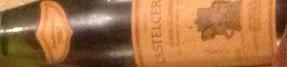

93
confidence:  1.0 /t IsOccluded:  1 /t IsTruncated:  1 /t IsGroup:  0 /t IsDepiction:  0 /t IsInside:  0 /t pred_label:  wardrobe /t pred_prob:  0.92836213 /t ocr text:   /t ocr text:  


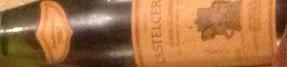

38
confidence:  1.0 /t IsOccluded:  0 /t IsTruncated:  1 /t IsGroup:  0 /t IsDepiction:  0 /t IsInside:  0 /t pred_label:  wine_bottle /t pred_prob:  0.68879205 /t ocr text:  c o rlole l si neeyas 2011 s ingovese aren l /t ocr text:  0 8 5 E C 0 RIOLE v | N E Y A R 20 11 Kegiovese IAREN


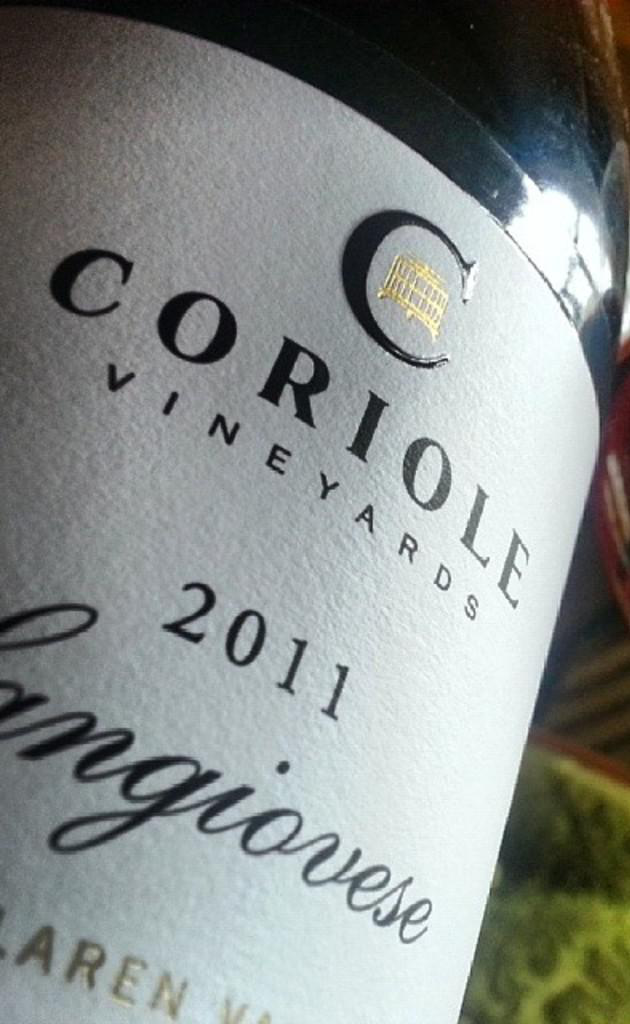

193
confidence:  1.0 /t IsOccluded:  1 /t IsTruncated:  0 /t IsGroup:  0 /t IsDepiction:  0 /t IsInside:  0 /t pred_label:  traffic_light /t pred_prob:  0.6247506 /t ocr text:   /t ocr text:  


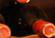

76
confidence:  1.0 /t IsOccluded:  1 /t IsTruncated:  1 /t IsGroup:  0 /t IsDepiction:  0 /t IsInside:  0 /t pred_label:  gong /t pred_prob:  0.6635796 /t ocr text:   /t ocr text:  


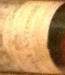

6
confidence:  1.0 /t IsOccluded:  0 /t IsTruncated:  0 /t IsGroup:  1 /t IsDepiction:  0 /t IsInside:  0 /t pred_label:  wine_bottle /t pred_prob:  0.17590035 /t ocr text:  s dnn diopstop /t ocr text:  "DopStop


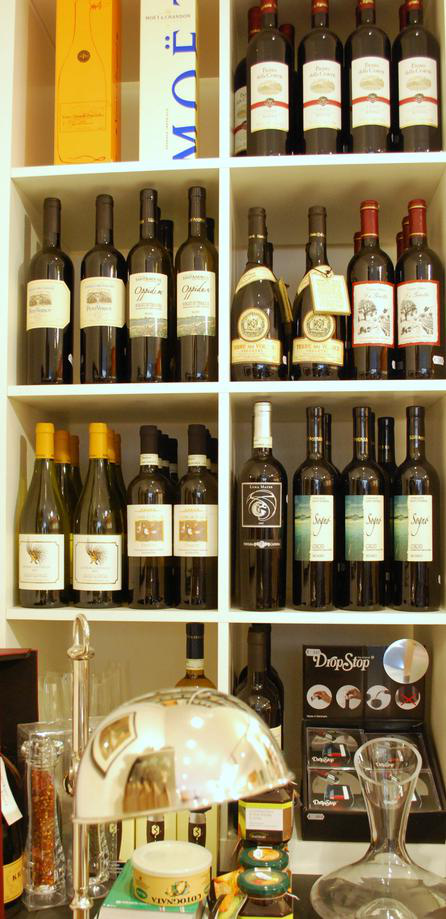

209
confidence:  1.0 /t IsOccluded:  1 /t IsTruncated:  0 /t IsGroup:  0 /t IsDepiction:  0 /t IsInside:  0 /t pred_label:  digital_clock /t pred_prob:  0.33361527 /t ocr text:   /t ocr text:  


11
confidence:  1.0 /t IsOccluded:  0 /t IsTruncated:  0 /t IsGroup:  0 /t IsDepiction:  0 /t IsInside:  0 /t pred_label:  wine_bottle /t pred_prob:  0.27096432 /t ocr text:  fevu cuabl grande s bougros lliam feyn oou /t ocr text:  GRANn Bo Ros FEYR Fu (Hariis, MILLAM


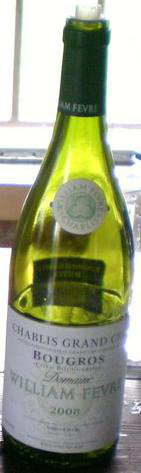

26
confidence:  1.0 /t IsOccluded:  0 /t IsTruncated:  0 /t IsGroup:  0 /t IsDepiction:  0 /t IsInside:  0 /t pred_label:  consomme /t pred_prob:  0.34605142 /t ocr text:   /t ocr text:  


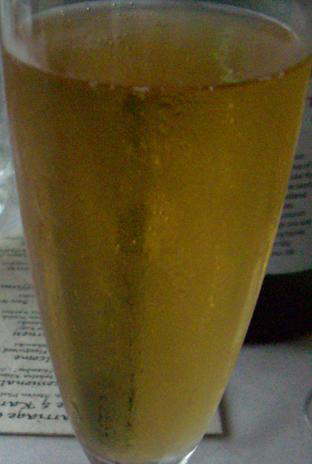

135
confidence:  1.0 /t IsOccluded:  0 /t IsTruncated:  1 /t IsGroup:  0 /t IsDepiction:  0 /t IsInside:  0 /t pred_label:  beer_bottle /t pred_prob:  0.31815287 /t ocr text:  zwanze 2010 biere tenmenter de mne tenments couunent va gion naute dune brassere remvitonnement de lambic dant on hs reines sont satvages lvures tancitnne gelle blnohe vous domnets d en l fposs hoc bier hoge ting temmenteren tal cen van gs gaan m wilde overheeren lambikbrouwen de gisten waar gen di antwoord d gaditionele witbier gaett het u the how lement wall wigh beer id fementa hion s wild yeast where mronnent lambic brewely ol d amswer the ptevanl d this yon old white beer syle give moubon 877 ngreien auntne 650 nalt ooks s froent ror 6ed ingeditanten sed harer ooes moul tarwe nor ingiedients ehh oals mall golo 85h wheat with 2008 bewed apnil at cantillon 21 brewery tne sennel te la de collaboration bne debaets yvan ot boleed cs mach 2010 f mao alc yo doten gum cantlon be luu brussoles /t ocr text:  Zwanze 20

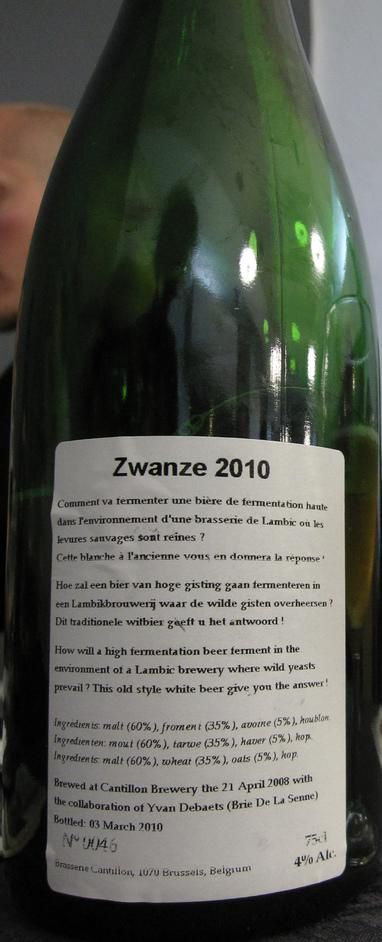

In [69]:
import random
random.randrange(2, 20)

for i in range(10):

    ix = random.randint(0, 263)
    print(ix)
    i = Image.open(io.BytesIO(wine_images_test_1_df.iloc[ix]['SubImageData']))
    print('confidence: ', wine_images_test_1_df.iloc[ix]['Confidence'],'/t', 'IsOccluded: ', wine_images_test_1_df.iloc[ix]['IsOccluded'], \
        '/t', 'IsTruncated: ', wine_images_test_1_df.iloc[ix]['IsTruncated'], \
        '/t', 'IsGroup: ', wine_images_test_1_df.iloc[ix]['isGroupOf'], \
        '/t', 'IsDepiction: ', wine_images_test_1_df.iloc[ix]['IsDepiction'], \
        '/t', 'IsInside: ', wine_images_test_1_df.iloc[ix]['IsInside'], \
        '/t', 'pred_label: ', wine_images_test_1_df.iloc[ix]['pred_label'] ,\
        '/t', 'pred_prob: ', wine_images_test_1_df.iloc[ix]['pred_prob'] ,\
        '/t', 'ocr text: ', wine_images_test_1_df.iloc[ix]['ocr'] ,\
        '/t', 'ocr text: ', wine_images_test_1_df.iloc[ix]['easy_ocr'] 
         )
    # plt.hist(i.histogram())
    i.save(wine_images_test_1_df.iloc[ix]['ImageID']+'_'+str(wine_images_test_1_df.iloc[ix]['n'])+".JPEG", format='JPEG')
    i.show()
 


Let's read the wine_test dataset after the prediction with new predicted attributes to explore it.

In [77]:

#reading wine test predicted dataset
# wine_pred_df = pd.read_csv('wine_images_test_pred_labels.csv', index_col=0)
wine_pred_df =wine_images_test_1_df.copy(deep=True)
wine_pred_df['pred_prob']=wine_pred_df['pred_prob'].astype(float)
wine_pred_df.head()

,ImageID,LabelName,Confidence,IsOccluded,IsTruncated,isGroupOf,IsDepiction,IsInside,SubImageData,n,grp,pred_label,pred_prob,ocr,easy_ocr
0,3e5601511f20796c,/m/081qc,1.0,0,0,1,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",0,0,beer_bottle,0.27335188,,
1,3e5601511f20796c,/m/081qc,1.0,1,0,0,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",1,1,digital_clock,0.26520517,,
2,3e5601511f20796c,/m/081qc,1.0,1,0,1,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",2,2,paintbrush,0.23806334,,
3,3e5601511f20796c,/m/081qc,1.0,1,0,1,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",3,3,otterhound,0.28727967,,
4,3e5601511f20796c,/m/081qc,1.0,1,0,1,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",4,4,chime,0.5954692,,


Let's see some basic statistics of the above dataset on the predicted labels and its predicted probability.

In [82]:
Labels = wine_pred_df.groupby('pred_label').agg(
                        Images = ('ImageID','size'),
                        Probability=('pred_prob', 'mean')
                        ).sort_values('Probability', ascending=False).reset_index()
Labels

,pred_label,Images,Probability
0,wardrobe,1,0.928362
1,clog,1,0.886796
2,pill_bottle,2,0.849603
3,reel,2,0.831745
4,red_wine,28,0.750338
...,...,...,...
85,miniature_pinscher,1,0.107424
86,container_ship,1,0.088095
87,Old_English_sheepdog,1,0.084411
88,horizontal_bar,1,0.064431


There are total 90 distinct predicted labels with its predicted probability reflected on the above results. **wardrobe** has the highest predicted probability of 0.9 and **red_wolf** has score of 0, however they only have 1 image each. Let's plot the numbers and see the labels with top 20 Probability score.

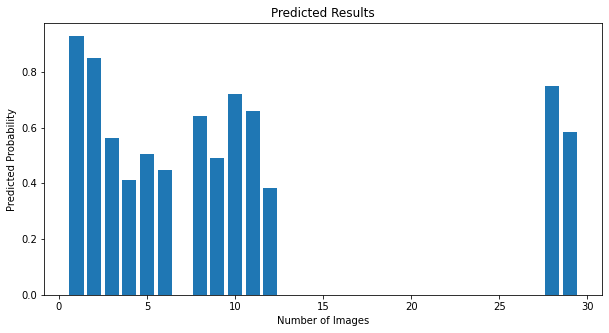

In [83]:
fig,ax = plt.subplots(figsize = (10, 5))
plt.bar(Labels['Images'],Labels['Probability'])
plt.xlabel('Number of Images')
plt.ylabel('Predicted Probability')
plt.title('Predicted Results')
 
# Show Plot
plt.show()

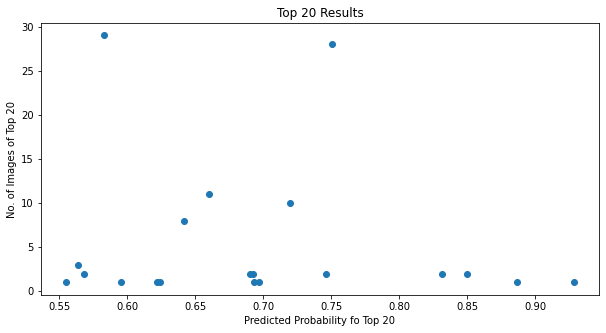

In [87]:
#finding top 20 probability score
top_20 = Labels.nlargest(n=20, columns= ['Probability'])
top_20
fig,ax = plt.subplots(figsize = (10, 5))
plt.scatter(top_20['Probability'], top_20['Images'])
plt.ylabel('No. of Images of Top 20')
plt.xlabel('Predicted Probability fo Top 20')
plt.title('Top 20 Results')
 
# Show Plot
plt.show()

We are interested on the predicted probability of the wine and bottle images. Lets fetch the results for the same only.

In [88]:
import re
wine = Labels[Labels['pred_label'].str.contains('wine')]
wine

,pred_label,Images,Probability
4,red_wine,28,0.750338
16,wine_bottle,29,0.582632


As we see in the above results, predicted probability is **0.75 for red_wine**, which is not bad. **wine_bottle** has less predicted probability score of **0.58**. Though the number of images are more compared to the other labels in the dataset, which shows the consistency of predicted probability.

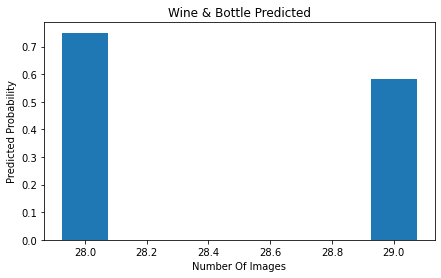

In [91]:
fig,ax = plt.subplots(figsize = (7, 4))
plt.bar(wine['Images'], wine['Probability'], width=0.15)
plt.xlabel('Number Of Images')
plt.ylabel('Predicted Probability')
plt.title('Wine & Bottle Predicted')
plt.show()

In [92]:
print('Null values in easy_ocr reading:', wine_pred_df['easy_ocr'].isnull().sum())

Null values in easy_ocr reading: 0


In [111]:
#counts of distinct OCR values.
wine_pred_df['easy_ocr'].value_counts()
wine_pred_df['ocr'].value_counts()

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              189
"DopStop                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        2
1   


## -999999 is an OCR image error. Something about those images caused an exception. Let's try to filter the predicted labels for the images with these error. -->

In [112]:
wine_pred_df[wine_pred_df['easy_ocr'] == '-999999']

,ImageID,LabelName,Confidence,IsOccluded,IsTruncated,isGroupOf,IsDepiction,IsInside,SubImageData,n,grp,pred_label,pred_prob,ocr,easy_ocr


In [113]:

img_error = wine_pred_df[wine_pred_df['easy_ocr'] == '-999999']
img_error['pred_label'].unique()

array([], dtype=object)

In [142]:
# wine_pred_df.pred_label.value_counts().sort_values().plot.barh(figsize=(30,30))

In [145]:
wine_pred_df[wine_pred_df['pred_label'].str.contains('wine')].head()

,ImageID,LabelName,Confidence,IsOccluded,IsTruncated,isGroupOf,IsDepiction,IsInside,SubImageData,n,grp,pred_label,pred_prob,ocr,easy_ocr
6,6e3b7f53e8b75c69,/m/081qc,1.0,0,0,1,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",6,6,wine_bottle,0.175900,s dnn diopstop,"""DopStop"
7,6e3b7f53e8b75c69,/m/081qc,1.0,0,0,1,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",7,7,wine_bottle,0.557250,s one dopstop,"""DopStop"
8,caa44bce1d51cee3,/m/081qc,1.0,0,1,0,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",8,8,wine_bottle,0.608671,premns behaune blls cow fev ulliam bot,"ABLL FF"" WLLAm PRE RTl"
9,caa44bce1d51cee3,/m/081qc,1.0,0,0,0,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",9,9,wine_bottle,0.311293,remietc lablis vatllons feye ulliam od,JLLON ou FREMIER A6lis FBTA MiLLIAT
10,caa44bce1d51cee3,/m/081qc,1.0,0,0,0,0,0,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",10,0,wine_bottle,0.257887,premlees abls vaulorent feye lliam adn,PREMIA ILORENI LIS ` MLLIAM FEVA


,IsOccluded,IsTruncated,isGroupOf,pred_prob
IsOccluded,1.000000,0.153998,0.033211,-0.014172
IsTruncated,0.153998,1.000000,-0.027277,-0.066853
isGroupOf,0.033211,-0.027277,1.000000,0.167043
pred_prob,-0.014172,-0.066853,0.167043,1.000000


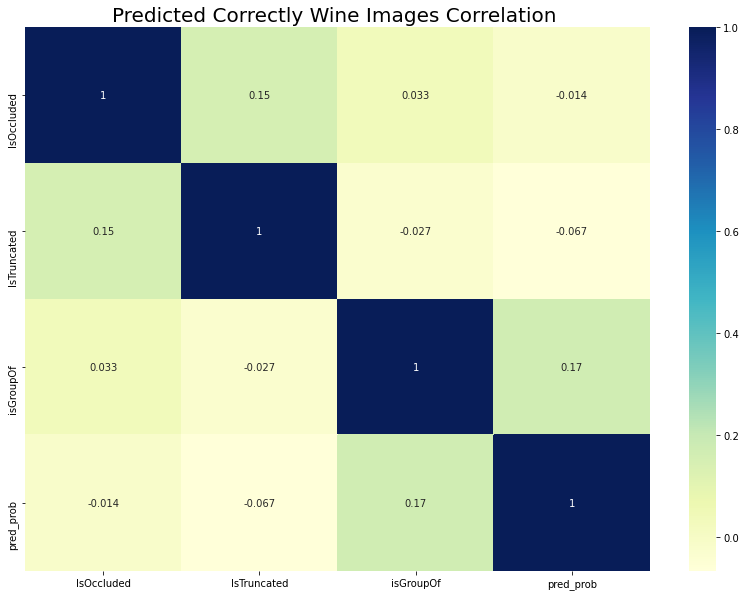

In [192]:
#computing correlation for the above results to show if the pred_prob shares any correlation with other attributes
pred_img_att_wine = wine_pred_df[wine_pred_df['pred_label'].str.contains('wine')][['IsOccluded','IsTruncated','isGroupOf','IsDepiction','IsInside','pred_prob']]
pred_img_att_wine.dtypes
pred_img_att_wine['IsOccluded']=pred_img_att_wine['IsOccluded'].astype('int')
# pred_img_att_wine['Confidence']=pred_img_att_wine['Confidence'].astype('int')
pred_img_att_wine['IsTruncated']=pred_img_att_wine['IsTruncated'].astype('int')
pred_img_att_wine['IsTruncated']=pred_img_att_wine['IsTruncated'].astype('int')
pred_img_att_wine['isGroupOf']=pred_img_att_wine['isGroupOf'].astype('int')
# pred_img_att_wine['IsDepiction']=pred_img_att_wine['IsDepiction'].astype('int')
# pred_img_att_wine['IsInside']=pred_img_att_wine['IsInside'].astype('int')

f, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(pred_img_att_wine.dropna().corr(),cmap="YlGnBu", annot=True)
plt.title('Predicted Correctly Wine Images Correlation ', size=20)

# pred_img_att_wine['Confidence']=pd.to_numeric(pred_img_att_wine['Confidence'], errors='coerce') #.astype(int)
pred_img_att_wine.dropna().corr()

,IsOccluded,IsTruncated,isGroupOf,pred_prob
IsOccluded,1.000000,0.006050,-0.065391,-0.068149
IsTruncated,0.006050,1.000000,-0.008581,0.052205
isGroupOf,-0.065391,-0.008581,1.000000,-0.044609
pred_prob,-0.068149,0.052205,-0.044609,1.000000


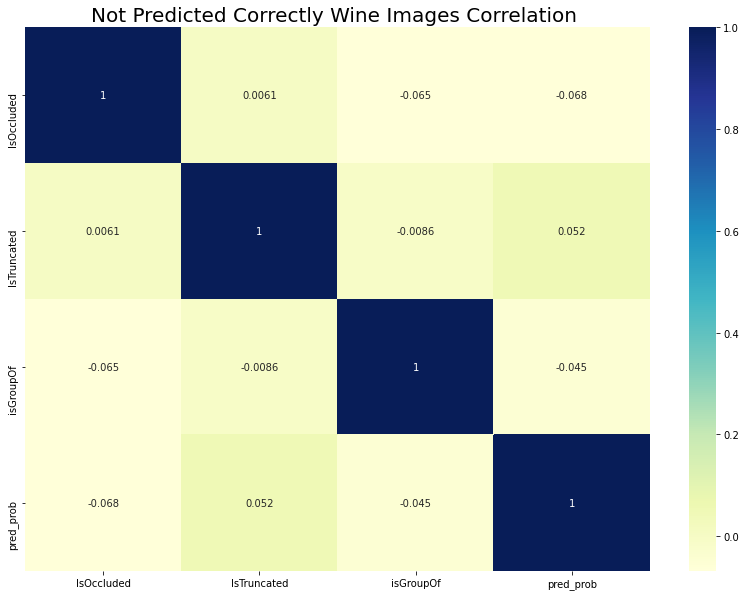

In [193]:

#computing correlation for the above results to show if the pred_prob shares any correlation with other attributes
pred_img_att_wine_not = wine_pred_df[~wine_pred_df['pred_label'].str.contains('wine')][['IsOccluded','IsTruncated','isGroupOf','IsDepiction','IsInside','pred_prob']]
pred_img_att_wine_not.dtypes
pred_img_att_wine_not['IsOccluded']=pred_img_att_wine_not['IsOccluded'].astype('int')
# pred_img_att_wine_not['Confidence']=pred_img_att_wine_not['Confidence'].astype('int')
pred_img_att_wine_not['IsTruncated']=pred_img_att_wine_not['IsTruncated'].astype('int')
pred_img_att_wine_not['IsTruncated']=pred_img_att_wine_not['IsTruncated'].astype('int')
pred_img_att_wine_not['isGroupOf']=pred_img_att_wine_not['isGroupOf'].astype('int')
# pred_img_att_wine_not['IsDepiction']=pred_img_att_wine_not['IsDepiction'].astype('int')
# pred_img_att_wine_not['IsInside']=pred_img_att_wine_not['IsInside'].astype('int')

f, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(pred_img_att_wine_not.dropna().corr(),cmap="YlGnBu", annot=True)
plt.title('Not Predicted Correctly Wine Images Correlation ', size=20)


# pred_img_att_wine['Confidence']=pd.to_numeric(pred_img_att_wine['Confidence'], errors='coerce') #.astype(int)
pred_img_att_wine_not.dropna().corr()

In [168]:
# pred_img_att_wine.query('Confidence==1.0')

In [189]:
# #filtering dataframe for only duckhorn ocr value
# duckhorn = wine_pred_df[wine_pred_df['easy_ocr'].notna()]
# duckhorn = duckhorn[duckhorn['easy_ocr']!='-999999']
# duckhorn['easy_ocr'].unique()

In [194]:
# duckhorn['pred_label'].unique()

In [190]:
# #getting only wine predicted labels
# duckhorn_wine = duckhorn[duckhorn['pred_label'].str.contains('wine')]
# duckhorn_wine.head(2)

# # UNABLE TO SAVE AVRO FILES WITH UDFS
# The following section does not work
# will not save

In [ ]:
# UNABLE TO SAVE AVRO FILES WITH UDFS
#est_few sec lazy operation
print(pd.Timestamp.now())
wine_images_test_1= wine_images_test_1 \
    .withColumn('ocr', udf_get_text(wine_images_test_1['SubImageData']))
print(pd.Timestamp.now())


#est_few sec lazy operation
print(pd.Timestamp.now())
wine_images_train_1= wine_images_train_1 \
    .withColumn('ocr', udf_get_text(wine_images_train_1['SubImageData']))
print(pd.Timestamp.now())

In [ ]:
#est_few sec lazy operation
print(pd.Timestamp.now())
wine_images_test_1= wine_images_test_1 \
    .withColumn('easy_ocr', udf_get_text(wine_images_test_1['SubImageData']))
print(pd.Timestamp.now())


# #est_few sec lazy operation
# print(pd.Timestamp.now())
# wine_images_train_1= wine_images_train_1 \
#     .withColumn('easy_ocr', udf_easy_ocr(wine_images_train_1['SubImageData']))
print(pd.Timestamp.now())

In [ ]:
wine_images_train_1.printSchema()

In [ ]:
###NOT WORKING
print(pd.Timestamp.now())
col=['ImageID','Confidence','IsOccluded','IsTruncated','isGroupOf','IsDepiction','IsInside','pred_label','ocr','easy_ocr','grp']

# wine_images_test_1.select(col).write.format('avro').mode('overwrite').option("header", "true").partitionBy("grp").save("/user/oe74376/Project/images_wine_bottle_test_pred_text_step3")
print(pd.Timestamp.now())

In [ ]:
#not_working
print(pd.Timestamp.now())
wine_images_train_1.write.format('avro').mode('overwrite').option("header", "true").partitionBy("grp").save("/user/oe74376/Project/images_wine_bottle_train_pred_text_step3")#.csv("/user/oe74376/Project/images_train_wine_bottle")
print(pd.Timestamp.now())

In [ ]:
#DOES NOT WORK WHEN OCR AND EASY OCR HAVE BEEN APPLIED ON THE AVRO
# print(pd.Timestamp.now())
# wine_images_test_1_df = wine_images_test_1.toPandas()
# print(pd.Timestamp.now())


# wine_images_test_1_df.to_csv('wine_images_test_pred_labels.csv')
# print(pd.Timestamp.now())

# END of Project - Grant Access

In [ ]:
hdfs.ls('/user/oe74376/Project')

In [ ]:

print(hdfs.info('/user/oe74376/Project'))#493
hdfs.chmod('/user/oe74376/Project',0o0755)
print(hdfs.info('/user/oe74376/Project'))